# Домашнее задание

1. Попробуйте видоизменить параметры разобранной на уроке двухслойной нейронной сети таким образом, чтобы улучшить ее точность (число нейронов, число эпох , можно изменять число слоев).
2. Проведите анализ — что приводит к ухудшению точности нейронной сети? Что приводит к увеличению ее точности?

In [1]:
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Times New Roman'
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.model_selection import train_test_split

In [2]:
### Шаг 1. Определение функций, которые понадобяться для обучения
# преобразование массива в бинарный вид результатов
def to_one_hot(Y):
    n_col = np.amax(Y) + 1
    binarized = np.zeros((len(Y), n_col))
    for i in range(len(Y)):
        binarized[i, Y[i]] = 1.
    return binarized

# преобразование массива в необходимый вид
def from_one_hot(Y):
    arr = np.zeros((len(Y), 1))

    for i in range(len(Y)):
        l = Y[i]
        for j in range(len(l)):
            if(l[j] == 1):
                arr[i] = j+1
    return arr

# сигмоида и ее производная
def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_deriv(x):
    return (x)*(1 - (x))

# нормализация массива
def normalize(X, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(X, order, axis))
    l2[l2 == 0] = 1
    return X / np.expand_dims(l2, axis)

In [3]:

### Шаг 2. Подготовка тренировочных данных
# получения данных из csv файла. укажите здесь путь к файлу Iris.csv
iris_data = pd.read_csv("Iris.csv")

# замена текстовых значений на цифровые
iris_data['Species'].replace(['Iris-setosa', 'Iris-virginica', 'Iris-versicolor'], [0, 1, 2], inplace=True)

# формирование входных данных
columns = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
x = pd.DataFrame(iris_data, columns=columns)
#x = normalize(x.as_matrix())
x = normalize(x.values)

# формирование выходных данных(результатов)
columns = ['Species']
y = pd.DataFrame(iris_data, columns=columns)
#y = y.as_matrix()
y = y.values
y = y.flatten()
y = to_one_hot(y)

# Разделение данных на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33)

# ТЕСТ параметров 3-слойной НС

In [4]:
# функция запуск нейронной сети с заданными параметрами
def test_nn(X_train,
            X_test,
            y_train,
            y_test,
            n1_neurons: int = 5,
            n2_neurons: int = 5,
            lr: float = 0.01,
            n_epochs: int = 2500
            ):

    train_errors = []
    test_errors = []

    # зададим одинаковые начальные веса для всех тестов
    np.random.seed(13)
    # для входного слоя   - 4 входа, n1_neurons выхода
    w0 = 2*np.random.random((4, n1_neurons)) - 1
    # для 1 внутреннего слоя - n1_neurons входов, n2_neurons выхода
    w1 = 2*np.random.random((n1_neurons, n2_neurons)) - 1
    # для 2 внутреннего слоя - n2_neurons входов, 3 выхода
    w2 = 2*np.random.random((n2_neurons, 3)) - 1

    for i in range(n_epochs):
        layer0 = X_train
        layer1 = sigmoid(np.dot(layer0, w0))
        layer2 = sigmoid(np.dot(layer1, w1))
        layer3 = sigmoid(np.dot(layer2, w2))

        # обратное распространение(back propagation) с использованием градиентного спуска
        # производная функции потерь = производная квадратичных потерь
        layer3_error = y_train - layer3
        layer3_delta = layer3_error * sigmoid_deriv(layer3)

        layer2_error = layer3_delta.dot(w2.T)
        layer2_delta = layer2_error * sigmoid_deriv(layer2)

        layer1_error = layer2_delta.dot(w1.T)
        layer1_delta = layer1_error * sigmoid_deriv(layer1)

        # обновление весов
        w2 += layer2.T.dot(layer3_delta) * lr
        w1 += layer1.T.dot(layer2_delta) * lr
        w0 += layer0.T.dot(layer1_delta) * lr

        # ошибки модели на train
        error = np.mean(np.abs(layer3_error))
        train_errors.append(error)

        # ошибки на test
        layer0_t = X_test
        layer1_t = sigmoid(np.dot(layer0_t, w0))
        layer2_t = sigmoid(np.dot(layer1_t, w1))
        layer3_t = sigmoid(np.dot(layer2_t, w2))
        layer3_error_t = y_test - layer3_t
        error_t = np.mean(np.abs(layer3_error_t))
        test_errors.append(error_t)

    # метрики
    train_accuracy = (1 - error) * 100
    test_accuracy = (1 - error_t) * 100

    return train_errors, test_errors, train_accuracy, test_accuracy

## Проверка влияние количества нейронов в слоях на качество обучения

In [5]:
loss_dict_train = {}
loss_dict_test = {}
accuracy_dict_train = {}
accuracy_dict_test = {}

for n1_neurons in range(1,7):
    for n2_neurons in range(1,7):
        train_errors, test_errors, train_accuracy, test_accuracy = test_nn(X_train,
                                                                   X_test,
                                                                   y_train,
                                                                   y_test,
                                                                   n1_neurons=n1_neurons,
                                                                   n2_neurons=n2_neurons,
                                                                   lr=0.01,
                                                                   n_epochs=3000
                                                                   )
        key_dict = f'n1_{n1_neurons}_n2_{n2_neurons}'
        loss_dict_train[key_dict] = train_errors
        loss_dict_test[key_dict] = test_errors
        accuracy_dict_train[key_dict] = train_accuracy
        accuracy_dict_test[key_dict] = test_accuracy
        

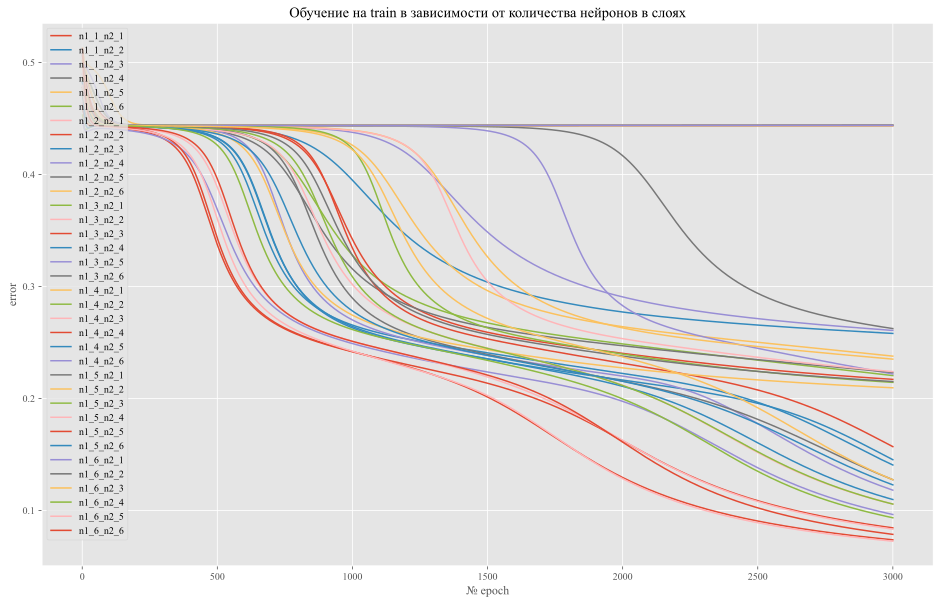

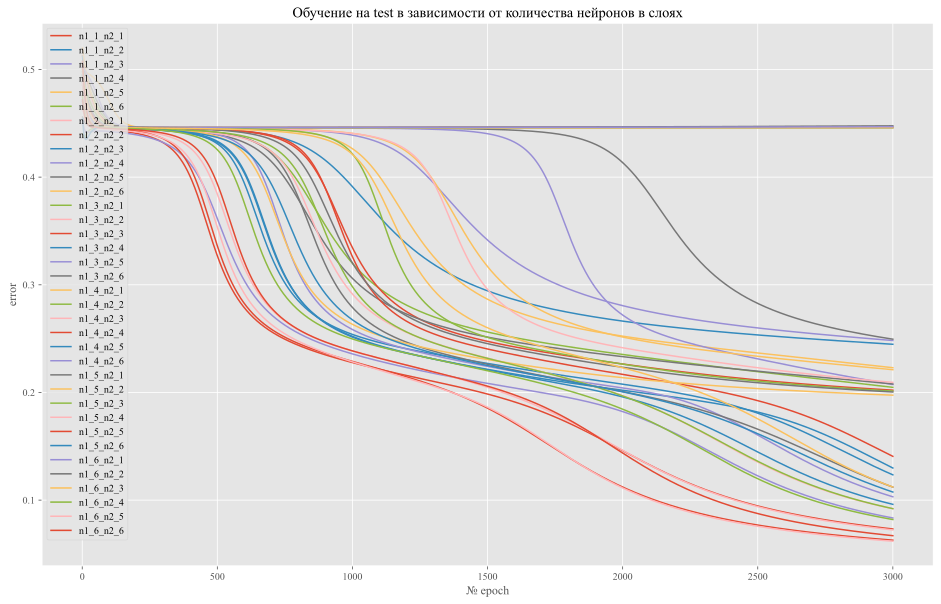

In [6]:
x = np.linspace(1, 3000, 3000)
plt.figure(figsize=(16, 10))
plt.xlabel('№ epoch')
plt.ylabel('error')
plt.title('Обучение на train в зависимости от количества нейронов в слоях')
for key in loss_dict_train:
    plt.plot(x, loss_dict_train[key], label=key)
    plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(16, 10))
plt.xlabel('№ epoch')
plt.ylabel('error')
plt.title('Обучение на test в зависимости от количества нейронов в слоях')
for key in loss_dict_test:
    plt.plot(x, loss_dict_test[key], label=key)
    plt.legend(loc='upper left')
plt.show()

## Для наглядности -

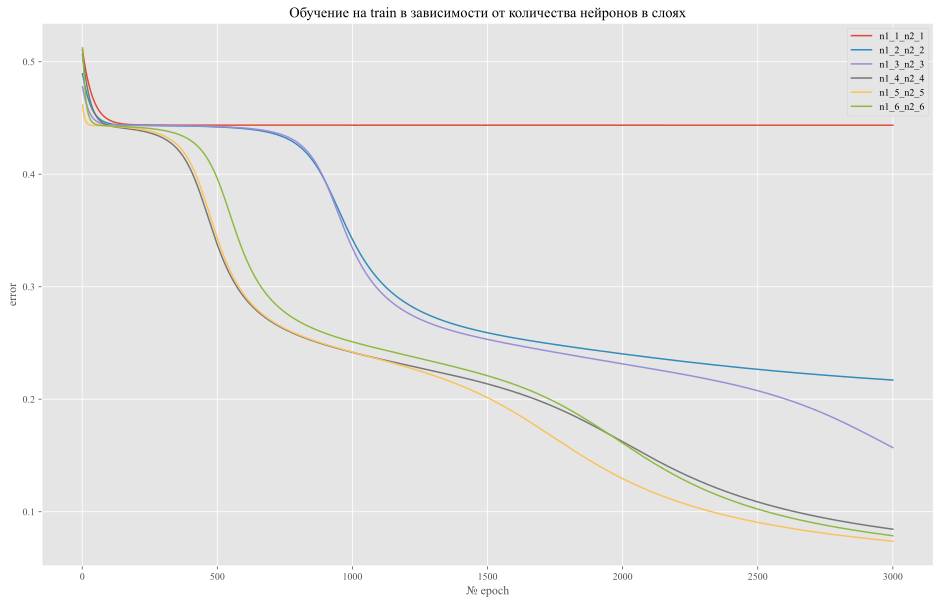

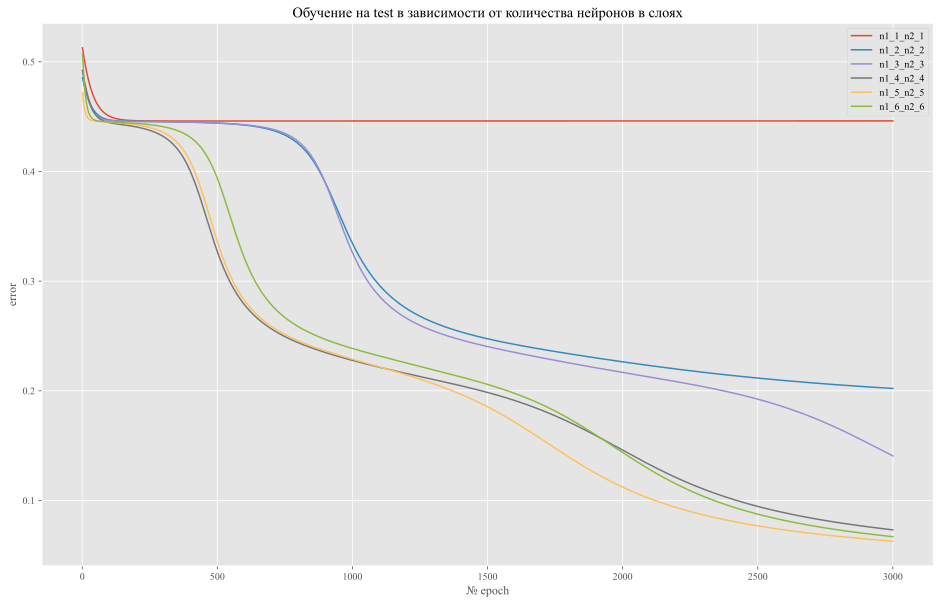

In [7]:
key_list = ['n1_1_n2_1', 'n1_2_n2_2', 'n1_3_n2_3', 'n1_4_n2_4', 'n1_5_n2_5', 'n1_6_n2_6']

# обучение на train
plt.figure(figsize=(16, 10))
plt.xlabel('№ epoch')
plt.ylabel('error')
plt.title('Обучение на train в зависимости от количества нейронов в слоях')
for key in key_list:
    plt.plot(x, loss_dict_train[key], label=key)
    plt.legend(loc='best')
plt.show()

# обучение на test
plt.figure(figsize=(16, 10))
plt.xlabel('№ epoch')
plt.ylabel('error')
plt.title('Обучение на test в зависимости от количества нейронов в слоях')
for key in key_list:
    plt.plot(x, loss_dict_test[key], label=key)
    plt.legend(loc='best')
plt.show()

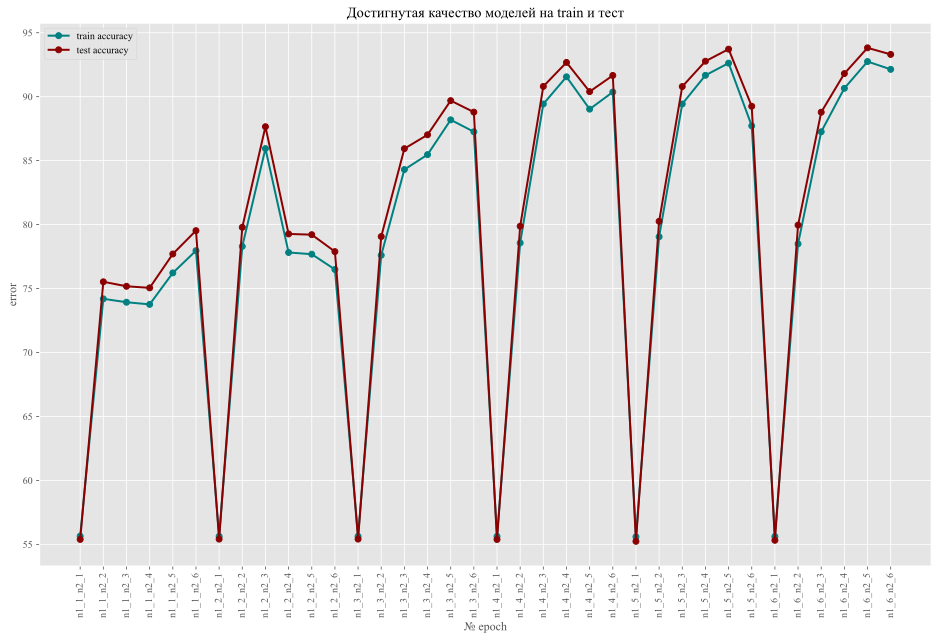

In [8]:
plt.figure(figsize=(16, 10))
plt.xlabel('№ epoch')
plt.ylabel('error')
plt.title('Достигнутая качество моделей на train и тест')
plt.plot(accuracy_dict_train.keys(), accuracy_dict_train.values(), color='teal',
         marker='o',  linewidth=2, label='train accuracy')
plt.plot(accuracy_dict_test.keys(), accuracy_dict_test.values(), color='darkred',
         marker='o',  linewidth=2, label='test accuracy')
plt.legend(loc='best')
plt.xticks(rotation=90)
plt.show()

In [9]:
# Проверка на большом количестве нейронов
train_errors, test_errors, train_accuracy, test_accuracy = test_nn(X_train,
                                                                       X_test,
                                                                       y_train,
                                                                       y_test,
                                                                       n1_neurons=25,
                                                                       n2_neurons=25,
                                                                       lr=0.05,
                                                                       n_epochs=3000
                                                                       )

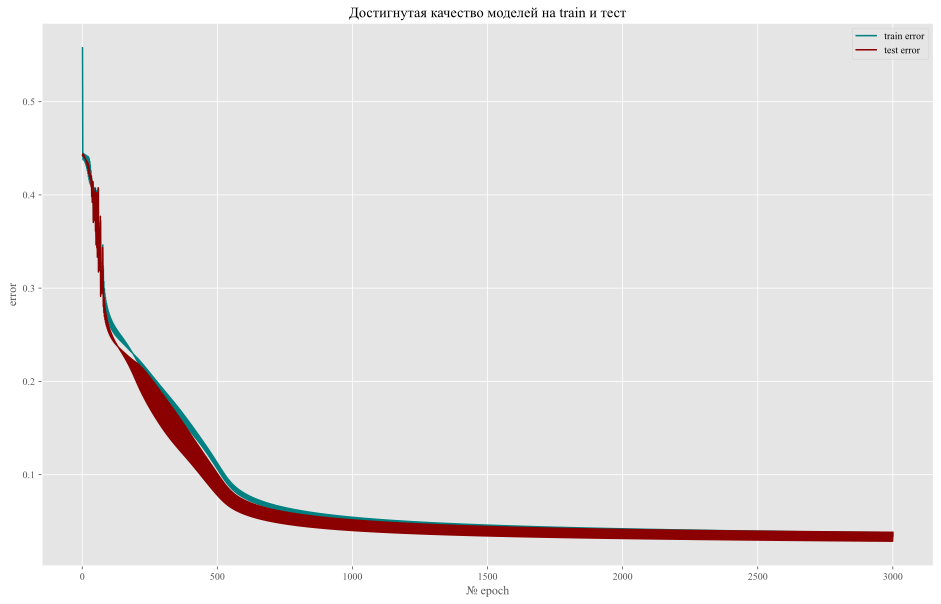

In [10]:
plt.figure(figsize=(16, 10))
plt.xlabel('№ epoch')
plt.ylabel('error')
plt.title('Достигнутая качество моделей на train и тест')
plt.plot(x, train_errors, color='teal', label='train error')
plt.plot(x, test_errors, color='darkred',label='test error')
plt.legend(loc='best')
plt.show()

## Проверка влияния скорости обучения на качество модели

In [11]:
loss_dict_train = {}
loss_dict_test = {}
accuracy_dict_train = {}
accuracy_dict_test = {}

for lr in [0.001, 0.005, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5]:

    train_errors, test_errors, train_accuracy, test_accuracy = test_nn(X_train,
                                                                       X_test,
                                                                       y_train,
                                                                       y_test,
                                                                       n1_neurons=5,
                                                                       n2_neurons=5,
                                                                       lr=lr,
                                                                       n_epochs=3000
                                                                       )
    key_dict = f'lr_{lr}'
    loss_dict_train[key_dict] = train_errors
    loss_dict_test[key_dict] = test_errors
    accuracy_dict_train[key_dict] = train_accuracy
    accuracy_dict_test[key_dict] = test_accuracy

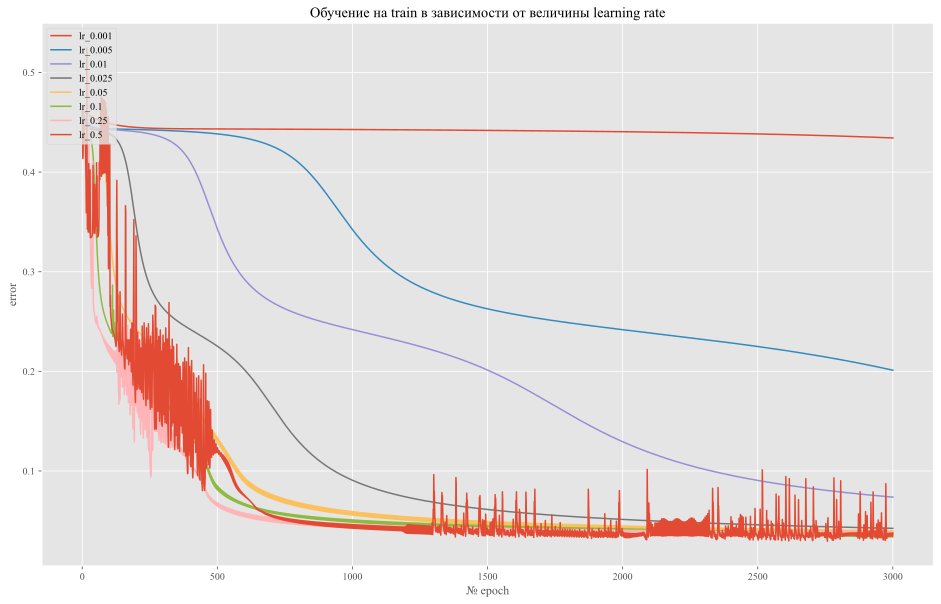

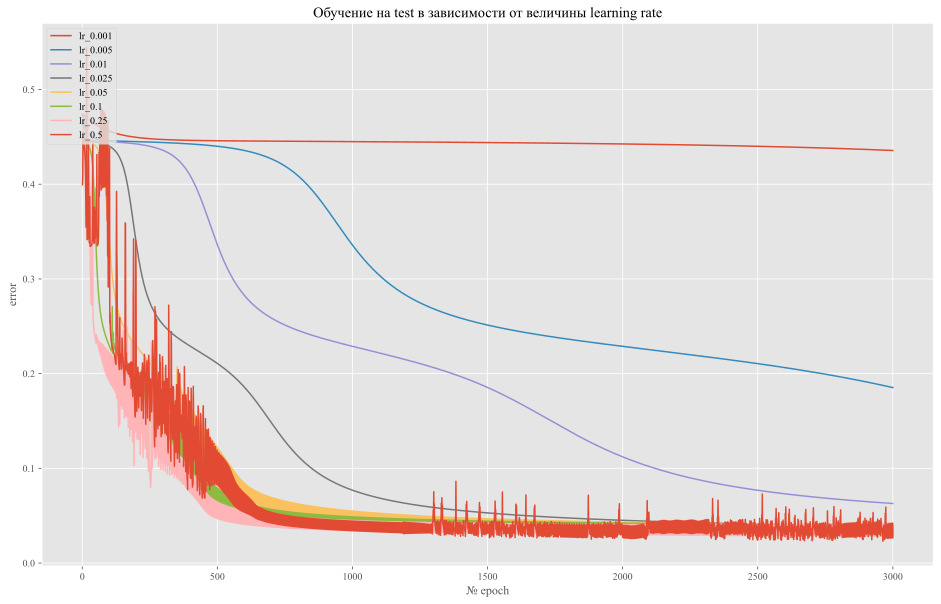

In [12]:
plt.figure(figsize=(16, 10))
plt.xlabel('№ epoch')
plt.ylabel('error')
plt.title('Обучение на train в зависимости от величины learning rate')
for key in loss_dict_train:
    plt.plot(x, loss_dict_train[key], label=key)
    plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(16, 10))
plt.xlabel('№ epoch')
plt.ylabel('error')
plt.title('Обучение на test в зависимости от величины learning rate')
for key in loss_dict_test:
    plt.plot(x, loss_dict_test[key], label=key)
    plt.legend(loc='upper left')
plt.show()

Вывод: в общем случае увеличение числа нейронов в слое ведет к улучшению качества модели, однако при значительном увеличении - растет variance. Увеличение числа слоев в зависимости от задачи может вести к улучшению качества модели. Однако в данном случае добавление третьего слоя скорее излишне (усложение модели). т.к. двухслойная модель показала примерно такие же результаты (+- из-за неустановленного random_seed). learning rate с в сочетании с числом эпох отвечают за сходимость модели: слишком маленький шаг и число эпох могут привести к тому, что не будет достигнут минимум функции потерь или к зависанию на локальных минимумах.
Слишком большой learning rate увеличивает variance и может привести к тому что модель при обучении будет выскакивать из минимумов.